In [1]:
import os
import numpy as np
import pandas as pd
import importlib
from psifr import fr
from cfr import framework
from cymr import network

model_dir = '/Users/morton/Dropbox/work/cmr_cfr/cfr'
data_file = os.path.join(model_dir, 'cfr_eeg_mixed.csv')
patterns_file = os.path.join(model_dir, 'cfr_patterns.hdf5')
fit_dir = os.path.join(model_dir, 'fits', 'v3')
fig_dir = '/Users/morton/manuscripts/cfr/figs/cfr'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

## Read observed and simulated data

In [2]:
patterns = network.load_patterns(patterns_file)
rsm = patterns['similarity']['use']

In [3]:
components = ['loc', 'cat', 'use', 'loc-cat', 'loc-use', 'cat-use', 'loc-cat-use']
models = [f'cmr_fcf-{comp}' for comp in components]
model_names = ['I', 'C', 'S', 'IC', 'IS', 'CS', 'ICS']
data = framework.read_model_sims(data_file, fit_dir, models, model_names)

In [4]:
data.head()

subject  list                   item  input  output  study  \
source trial                                                               
data   0            1     2              SEAN PENN    1.0     5.0   True   
       1            1     2         AUDREY HEPBURN    2.0     NaN   True   
       2            1     2  ST PATRICKS CATHEDRAL    3.0    11.0   True   
       3            1     2          LES INVALIDES    4.0     NaN   True   
       4            1     2   GREAT ZIMBABWE RUINS    5.0     NaN   True   

              recall  repeat  intrusion  session list_type list_category  \
source trial                                                               
data   0        True       0      False      1.0     mixed         mixed   
       1       False       0      False      1.0     mixed         mixed   
       2        True       0      False      1.0     mixed         mixed   
       3       False       0      False      1.0     mixed         mixed   
       4       False       0      False      1.0     mixed         mixed   

              item_index category  block  n_block  block_pos  block_len  
source trial                                                             
data   0           228.0      cel    1.0      6.0        1.0        2.0  
       1            19.0      cel    1.0      6.0        2.0        2.0  
       2           463.0      loc    2.0      6.0        1.0        4.0  
       3           364.0      loc    2.0      6.0        2.0        4.0  
       4           340.0      loc    2.0      6.0        3.0        4.0

## Clustering for all models

In [5]:
lag_rank_within = data.groupby('source').apply(
    fr.lag_rank, test_key='category', test=lambda x, y: x == y
)

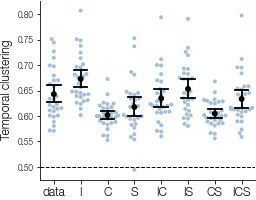

In [47]:
c = [.65, .75, .85]
g = fr.plot_swarm_error(lag_rank_within, x='source', y='rank', swarm_size=4,
                        height=3, aspect=1.2, swarm_color=c)
g.axes[0, 0].plot(g.axes[0, 0].get_xlim(), [.5, .5], '--k');
g.set(ylabel='Temporal clustering');
g.axes[0, 0].tick_params(axis='x', labelsize='large');
g.savefig(os.path.join(fig_dir, 'comp_lag_rank.pdf'))

In [7]:
cat_crp = data.groupby('source').apply(
    fr.category_crp, category_key='category'
)

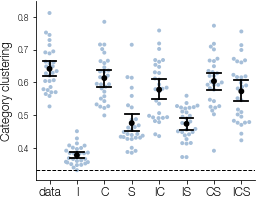

In [48]:
import importlib
import seaborn as sns
importlib.reload(sns)
importlib.reload(fr)
g = fr.plot_swarm_error(cat_crp, x='source', y='prob', swarm_size=4,
                        height=3, aspect=1.2, swarm_color=c)
g.axes[0, 0].plot(g.axes[0, 0].get_xlim(), [1/3, 1/3], '--k');
g.set(ylabel='Category clustering');
g.axes[0, 0].tick_params(axis='x', labelsize='large');
g.savefig(os.path.join(fig_dir, 'comp_cat_crp.pdf'))

In [9]:
use_rank = data.groupby('source').apply(
    fr.distance_rank, 'item_index', 1 - rsm, test_key='category',
    test=lambda x, y: x == y
)

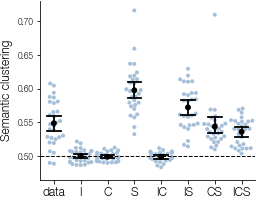

In [50]:
g = fr.plot_swarm_error(use_rank, x='source', y='rank', swarm_size=4,
                        height=3, aspect=1.2, swarm_color=c)
g.axes[0, 0].plot(g.axes[0, 0].get_xlim(), [.5, .5], '--k');
g.set(ylabel='Semantic clustering');
g.axes[0, 0].tick_params(axis='x', labelsize='large');
g.savefig(os.path.join(fig_dir, 'comp_use_rank.pdf'))

## Curves for a subset of models

In [11]:
sources = ['data', 'ICS', 'I', 'C', 'S']
comp = data.loc[sources]
opt = {'height': 2}

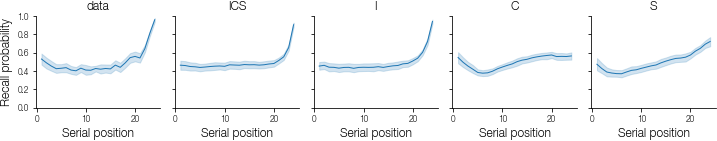

In [51]:
spc = comp.groupby('source').apply(fr.spc)
g = fr.plot_spc(spc, col='source', col_order=sources, **opt)
for i, name in enumerate(sources):
    g.axes[0, i].set_title(name)
g.savefig(os.path.join(fig_dir, 'spc.pdf'))

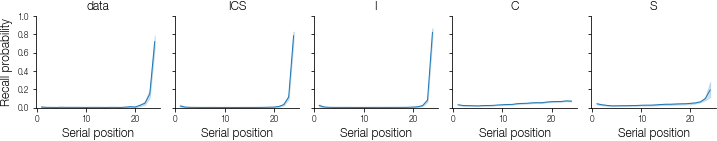

In [52]:
pfr = comp.groupby('source').apply(lambda x: fr.pnr(x).query('output == 1'))
g = fr.plot_spc(pfr, col='source', col_order=sources, **opt)
for i, name in enumerate(sources):
    g.axes[0, i].set_title(name)
g.savefig(os.path.join(fig_dir, 'pfr.pdf'))

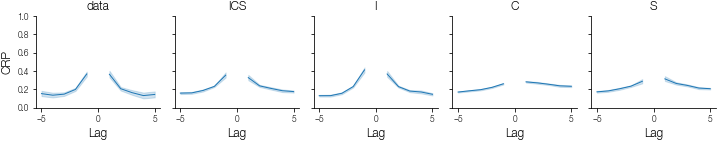

In [53]:
crp = comp.groupby('source').apply(fr.lag_crp, test_key='category', test=lambda x, y: x == y)
g = fr.plot_lag_crp(crp, col='source', col_order=sources, **opt)
for i, name in enumerate(sources):
    g.axes[0, i].set_title(name)
g.savefig(os.path.join(fig_dir, 'lag_crp.pdf'))

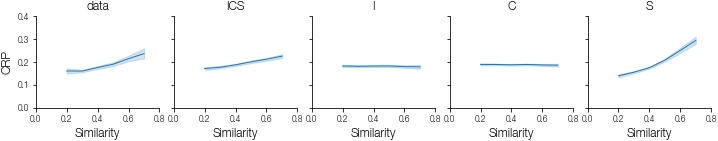

In [54]:
edges = np.linspace(.05, .95, 10)
min_samples=5

dcrp = comp.groupby('source').apply(
    fr.distance_crp, 'item_index', rsm, edges, 
    test_key='category', test=lambda x, y: x == y
)
g = fr.plot_distance_crp(dcrp, min_samples=min_samples, col='source', col_order=sources, **opt)
for i, name in enumerate(sources):
    g.axes[0, i].set_title(name)
g.set(xlim=(0, .8), ylim=(0, .4), xlabel='Similarity')
g.savefig(os.path.join(fig_dir, 'use_crp_within.pdf'))

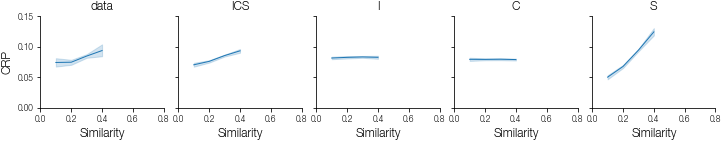

In [55]:
dcrp = comp.groupby('source').apply(
    fr.distance_crp, 'item_index', rsm, edges, 
    test_key='category', test=lambda x, y: x != y
)
g = fr.plot_distance_crp(dcrp, min_samples=min_samples, col='source', col_order=sources, **opt)
for i, name in enumerate(sources):
    g.axes[0, i].set_title(name)
g.set(xlim=(0, .8), ylim=(0, .15), xlabel='Similarity')
g.savefig(os.path.join(fig_dir, 'use_crp_across.pdf'))